In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, \
    precision_score, recall_score, f1_score
from scipy.stats import mode
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import os

# Data Normalization and Clean

In [2]:
print(os.listdir("./DatasetPM"))

['guangzhou.csv', '.ipynb_checkpoints', 'chengdu.csv', 'shanghai.csv', 'shenyang.csv', 'beijing.csv']


In [3]:
def load_datasets(directory):
    print("In load_datasets() function")
    temp_datasets = {}
    for file_name in os.listdir(directory):
        # Exclude non-CSV files
        if not file_name.endswith(".csv"):
            continue
        # Extract dataset name from the file name
        dataset_name = file_name.split(".csv")[0].lower()
        
        # Read the CSV file into a dataframe
        dataset = pd.read_csv(os.path.join(directory, file_name))
        
        # Parse the specified columns into a single datetime column 'dt'
        date_cols = ['year', 'month', 'day', 'hour']
        dataset['dt'] = pd.to_datetime(dataset[date_cols])
        
        # Set 'dt' as the datetime index
        dataset.set_index('dt', inplace=True)
        
        # Drop the individual date columns
        dataset.drop(columns=date_cols, inplace=True)
        
        # Store the dataframe in the dictionary with dataset_name as key
        temp_datasets[dataset_name] = dataset
    
    return temp_datasets


datasets = load_datasets("./DatasetPM")  # Provide the directory path here

In load_datasets() function


In [4]:
def mydropna(mydatasets):
    print("in mydropna() funciton")
    mytemp_datasets=dict()
    for city, dataset in mydatasets.items():
        mytemp_datasets[city]=dataset.dropna(axis=0, how="any")
        print("before subtracting ",city," dataset shape:",dataset.shape)
        print("after subtracting ",city," dataset shape:",mytemp_datasets[city].shape)
        print()
    
    return mytemp_datasets

In [5]:
# datasets=load_datasets()

In [6]:
datasets_na_dropped=mydropna(datasets)

in mydropna() funciton
before subtracting  guangzhou  dataset shape: (52584, 13)
after subtracting  guangzhou  dataset shape: (20074, 13)

before subtracting  chengdu  dataset shape: (52584, 13)
after subtracting  chengdu  dataset shape: (21074, 13)

before subtracting  shanghai  dataset shape: (52584, 13)
after subtracting  shanghai  dataset shape: (21436, 13)

before subtracting  shenyang  dataset shape: (52584, 13)
after subtracting  shenyang  dataset shape: (19038, 13)

before subtracting  beijing  dataset shape: (52584, 14)
after subtracting  beijing  dataset shape: (19062, 14)



In [7]:
for dataset_name, dataset in datasets_na_dropped.items():
    print(dataset_name.upper()," Measurement stations located in the city:")
    for column in dataset.columns.values:
        if "PM_" in column:
            print(column)
    print()

GUANGZHOU  Measurement stations located in the city:
PM_City Station
PM_5th Middle School
PM_US Post

CHENGDU  Measurement stations located in the city:
PM_Caotangsi
PM_Shahepu
PM_US Post

SHANGHAI  Measurement stations located in the city:
PM_Jingan
PM_US Post
PM_Xuhui

SHENYANG  Measurement stations located in the city:
PM_Taiyuanjie
PM_US Post
PM_Xiaoheyan

BEIJING  Measurement stations located in the city:
PM_Dongsi
PM_Dongsihuan
PM_Nongzhanguan
PM_US Post



In [8]:
for dataset_name, dataset in datasets_na_dropped.items():
    print(dataset_name," The first five lines of the data set:")
    print(dataset.head())

guangzhou  The first five lines of the data set:
                        No  season  PM_City Station  PM_5th Middle School  \
dt                                                                          
2013-01-01 00:00:00  26305     4.0             83.0                  78.0   
2013-01-01 01:00:00  26306     4.0             95.0                  70.0   
2013-01-01 03:00:00  26308     4.0             55.0                  66.0   
2013-01-01 04:00:00  26309     4.0             60.0                  69.0   
2013-01-01 05:00:00  26310     4.0             41.0                  51.0   

                     PM_US Post  DEWP  HUMI    PRES  TEMP cbwd  Iws  \
dt                                                                    
2013-01-01 00:00:00        83.0   3.7  91.0  1014.2   5.0   NW  1.9   
2013-01-01 01:00:00        95.0   4.2  88.0  1014.2   6.0   NW  3.4   
2013-01-01 03:00:00        55.0   3.5  76.0  1013.9   7.5   NW  5.8   
2013-01-01 04:00:00        60.0   2.7  69.0  1013.9   8.

# EDA

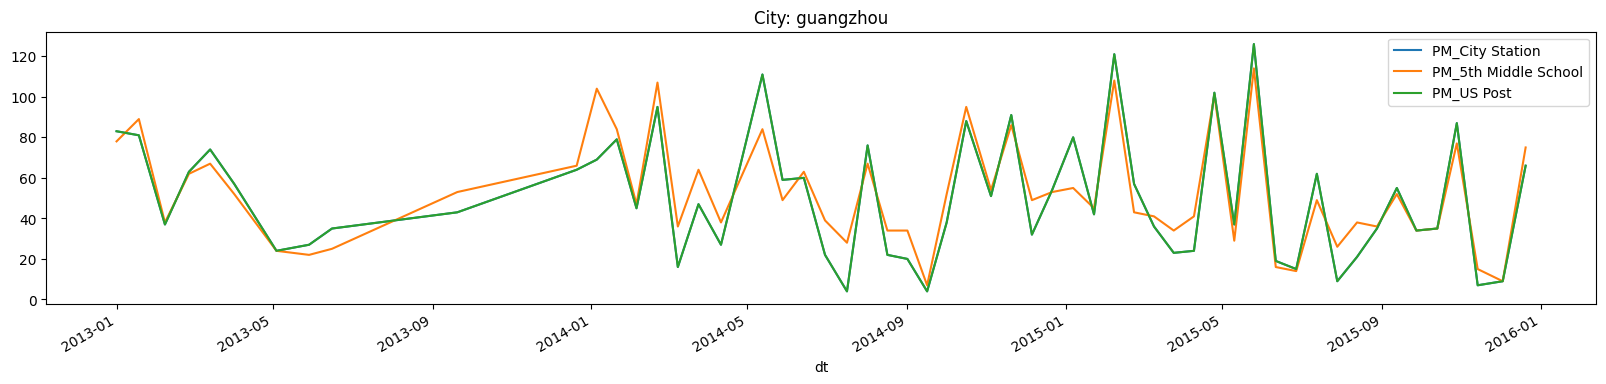

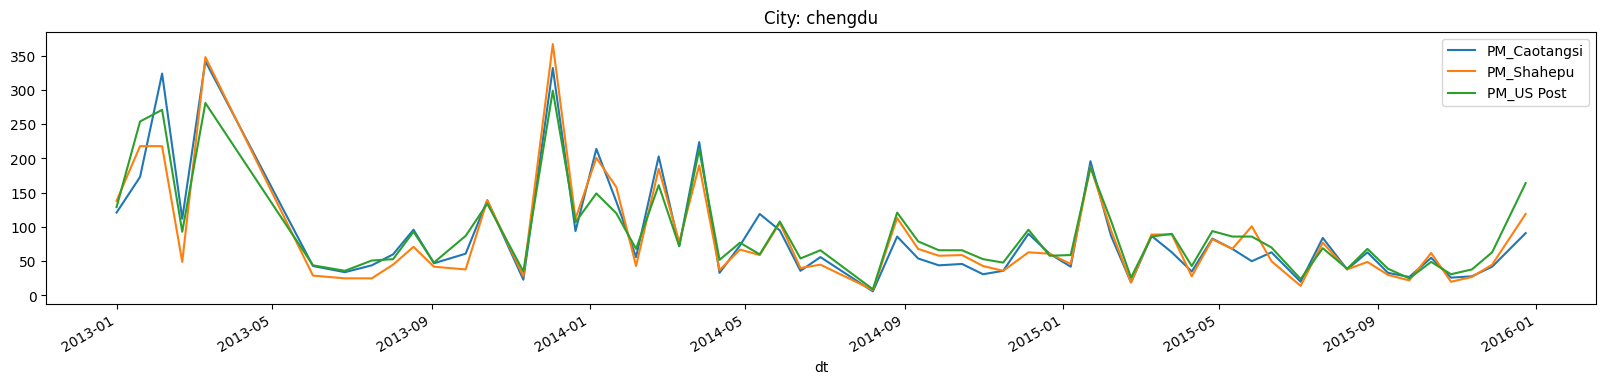

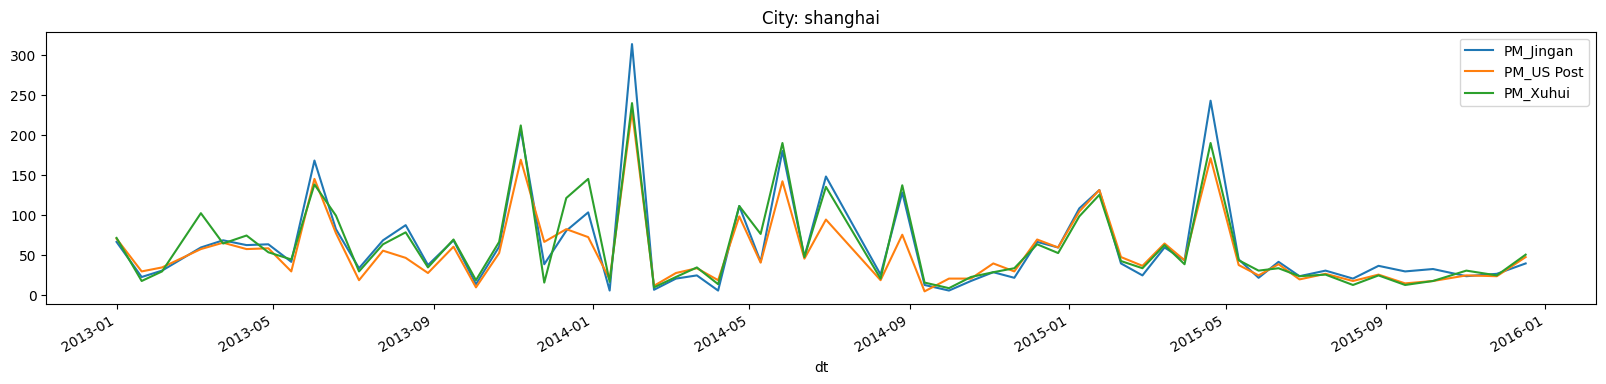

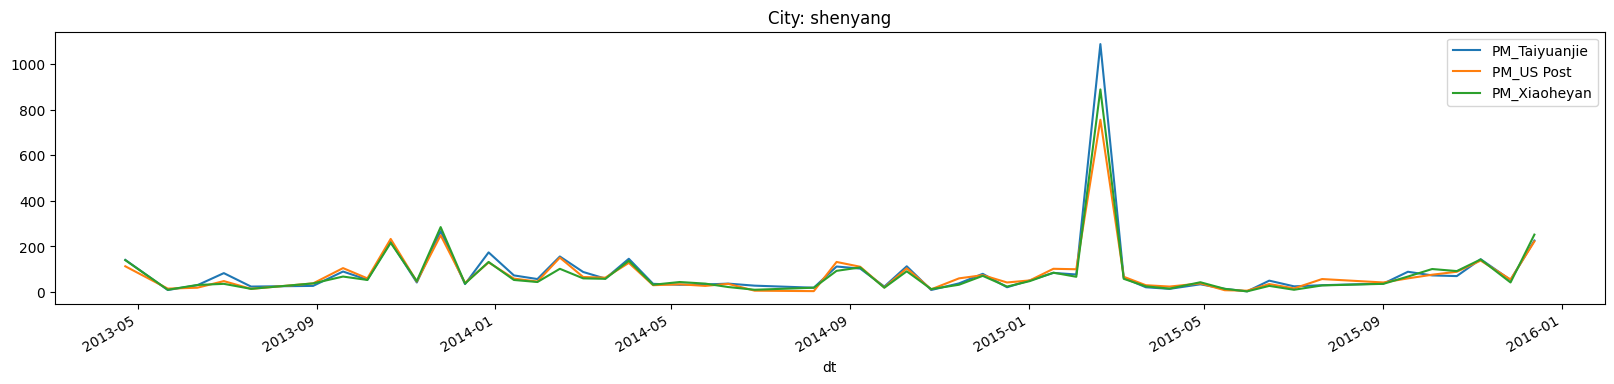

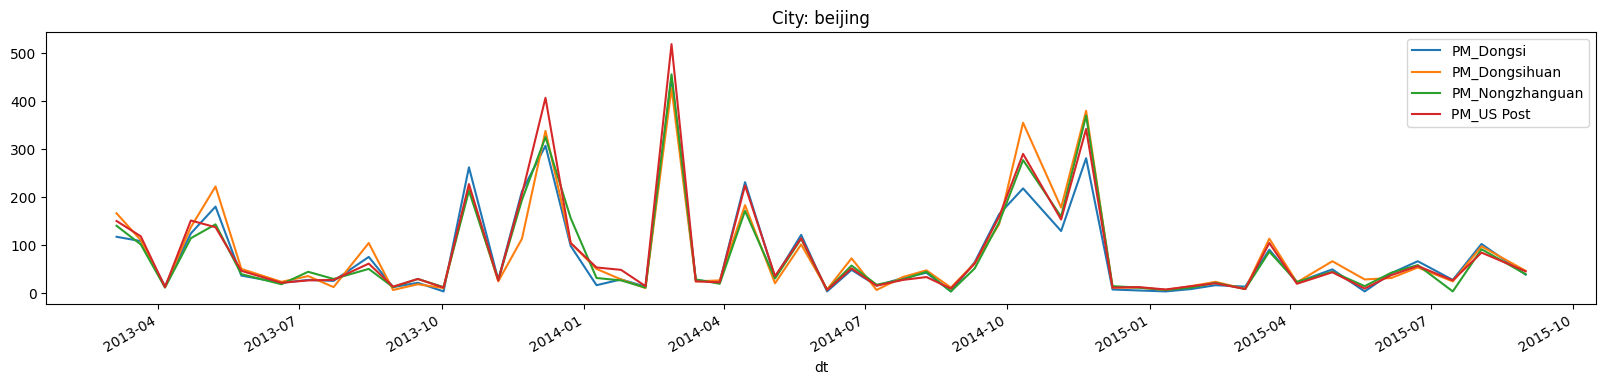

In [9]:
for city, dataset in datasets_na_dropped.items():
    columns = [column for column in dataset.columns if "PM_" in column]
    ax = datasets_na_dropped[city][columns][::360].plot(figsize=(20, 4), title="City: " + city)

plt.show()

There is consistency in the measurement data of different measurement stations where the data set is used and as stated in the academic studies of Liang et al. Therefore, it will be sufficient to use the data of one of the measurement stations.

In [10]:
for city, dataset in datasets.items():
    columns=list()
    for column in dataset.columns.values:
        if 'PM' in column:
            columns.append(column)
    print(city," Measurement numbers of measurement stations for the city:")
    print(dataset[columns].notnull().sum())

guangzhou  Measurement numbers of measurement stations for the city:
PM_City Station         32352
PM_5th Middle School    21095
PM_US Post              32352
dtype: int64
chengdu  Measurement numbers of measurement stations for the city:
PM_Caotangsi    24420
PM_Shahepu      24594
PM_US Post      28900
dtype: int64
shanghai  Measurement numbers of measurement stations for the city:
PM_Jingan     24700
PM_US Post    34039
PM_Xuhui      25189
dtype: int64
shenyang  Measurement numbers of measurement stations for the city:
PM_Taiyuanjie    24388
PM_US Post       21680
PM_Xiaoheyan     24627
dtype: int64
beijing  Measurement numbers of measurement stations for the city:
PM_Dongsi          25052
PM_Dongsihuan      20508
PM_Nongzhanguan    24931
PM_US Post         50387
dtype: int64


Since the most measurement data belongs to the US Post station, PM2.5 data of this station will be used. Let's remove non-US Post measuring stations in all cities

In [11]:
file_path = "./DatasetPM/beijing.csv"

df = pd.read_csv(file_path)
df.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [12]:
print("\nNumber of samples: ", df.shape[0])
print("\nNumber of features: ", df.shape[1])
print("\nInformation about features: \n", df.dtypes)

print('Days: ', df['day'].unique())
print('Hours: ', df['hour'].unique())
print('Season: ', df['season'].unique())
print('Years: ', df['year'].unique())
print('Months: ', df['month'].unique())
print('Wind direction values: ', df['cbwd'].unique())
print("\nMissing values: \n", df.isnull().sum() / df.shape[0] * 100)  # described in percents
print(df['PM_US Post'].describe())


Number of samples:  52584

Number of features:  18

Information about features: 
 No                   int64
year                 int64
month                int64
day                  int64
hour                 int64
season               int64
PM_Dongsi          float64
PM_Dongsihuan      float64
PM_Nongzhanguan    float64
PM_US Post         float64
DEWP               float64
HUMI               float64
PRES               float64
TEMP               float64
cbwd                object
Iws                float64
precipitation      float64
Iprec              float64
dtype: object
Days:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Hours:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Season:  [4 1 2 3]
Years:  [2010 2011 2012 2013 2014 2015]
Months:  [ 1  2  3  4  5  6  7  8  9 10 11 12]
Wind direction values:  ['NW' 'cv' 'NE' 'SE' nan]

Missing values: 
 No                  0.000000
year                0.000000

In [13]:
df.describe()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
count,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,25052.000000,20508.000000,24931.000000,50387.000000,52579.000000,52245.000000,52245.000000,52579.000000,52579.000000,52100.000000,52100.000000
mean,26292.500000,2012.499772,6.523962,15.726609,11.500000,2.491100,89.154439,92.560806,88.643737,95.904241,2.074554,54.602421,1016.465442,12.587040,23.261829,19.258683,19.519008
std,15179.837614,1.707485,3.448452,8.798896,6.922252,1.116988,87.239267,88.027434,88.041166,91.643772,14.222059,25.991338,10.295070,12.098527,49.281706,4381.035532,4381.036040
min,1.000000,2010.000000,1.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,1.000000,-40.000000,2.000000,991.000000,-19.000000,0.450000,0.000000,0.000000
25%,13146.750000,2011.000000,4.000000,8.000000,5.750000,1.000000,24.000000,28.000000,24.000000,27.000000,-10.000000,31.000000,1008.000000,2.000000,1.790000,0.000000,0.000000
50%,26292.500000,2012.000000,7.000000,16.000000,11.500000,2.000000,64.000000,68.000000,62.000000,69.000000,2.000000,55.000000,1016.000000,14.000000,4.920000,0.000000,0.000000
75%,39438.250000,2014.000000,10.000000,23.000000,17.250000,3.000000,124.000000,127.000000,122.000000,132.000000,15.000000,78.000000,1025.000000,23.000000,21.020000,0.000000,0.000000
max,52584.000000,2015.000000,12.000000,31.000000,23.000000,4.000000,737.000000,672.000000,844.000000,994.000000,28.000000,100.000000,1046.000000,42.000000,585.600000,999990.000000,999990.000000


In [14]:
# Drop features from other locations
df.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan'], axis=1, inplace=True)

# Drop features 'precipitation' and 'Iprec'
df.drop(['No', 'precipitation', 'Iprec'], axis=1, inplace=True)

# Check for missing values
print(df.isnull().sum() / df.shape[0] * 100)

year          0.000000
month         0.000000
day           0.000000
hour          0.000000
season        0.000000
PM_US Post    4.178077
DEWP          0.009509
HUMI          0.644683
PRES          0.644683
TEMP          0.009509
cbwd          0.009509
Iws           0.009509
dtype: float64


In [15]:
# For the most crucial feature, 'PM_US Post', we check whether more than 85% of data is missing for any year.
# If more than 85% of data is missing, then that year may not be considered relevant.
gbdf = df.groupby(by='year').agg('count')
del_year = gbdf.index[gbdf['PM_US Post'] / gbdf['month'] < 0.15]
df = df[~df['year'].isin(del_year)]
print(df['year'].unique())

[2010 2011 2012 2013 2014 2015]


In [16]:
df['PM_US Post'] = df['PM_US Post'].ffill()

df.dropna(axis=0, inplace=True)

print(df.isna().sum())


year          0
month         0
day           0
hour          0
season        0
PM_US Post    0
DEWP          0
HUMI          0
PRES          0
TEMP          0
cbwd          0
Iws           0
dtype: int64


In [17]:
print("\nNumber of samples: ", df.shape[0])
print("\nNumber of features: ", df.shape[1])


Number of samples:  52222

Number of features:  12


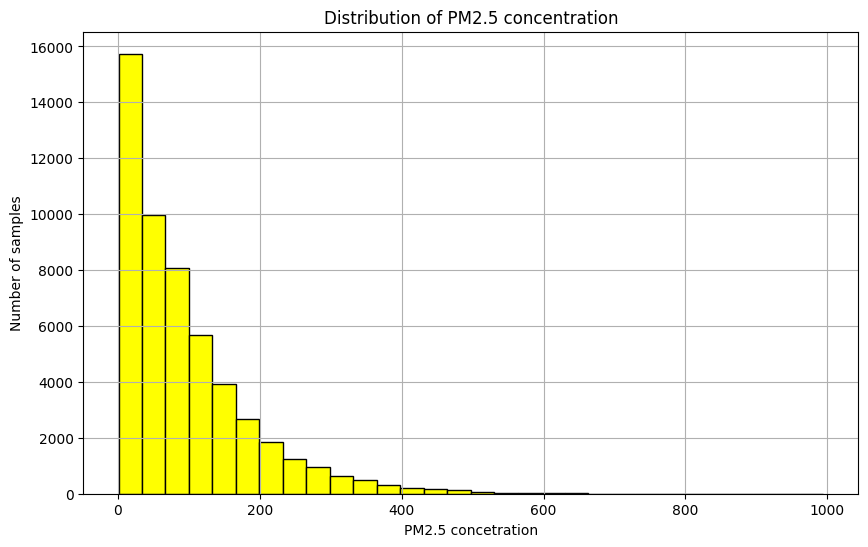

In [18]:
# Frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(df['PM_US Post'], bins=30, color='yellow', edgecolor='black')
plt.title('Distribution of PM2.5 concentration')
plt.xlabel('PM2.5 concetration')
plt.ylabel('Number of samples')
plt.grid(True)
plt.show()

In [19]:
# Central tendency measures
mean_value = np.mean(df['PM_US Post'])
median_value = np.median(df['PM_US Post'])
mode_value = mode(df['PM_US Post'], keepdims = True).mode[0]

print("Mean:", mean_value)
print("Median:", median_value)
print("Mode:", mode_value)

Mean: 95.13356439814638
Median: 69.0
Mode: 12.0


In [20]:
# Calculating IQR
Q1 = df['PM_US Post'].quantile(0.25)
Q3 = df['PM_US Post'].quantile(0.75)
IQR = Q3 - Q1

# Define borders for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 5 * IQR

# Identfication of outliers
outliers = df[(df['PM_US Post'] < lower_bound) | (df['PM_US Post'] > upper_bound)]['PM_US Post']

print("Identificated outliers:")
print(outliers)

Identificated outliers:
1056     980.0
1057     980.0
1875     700.0
1876     700.0
1877     700.0
1929     784.0
1930     761.0
18048    994.0
18049    972.0
26582    802.0
26583    845.0
26584    810.0
26585    776.0
26586    824.0
26587    886.0
26588    852.0
26589    858.0
26590    805.0
26591    744.0
26592    731.0
26593    722.0
26594    684.0
26596    673.0
35424    659.0
35427    671.0
46339    722.0
51834    654.0
51835    666.0
Name: PM_US Post, dtype: float64


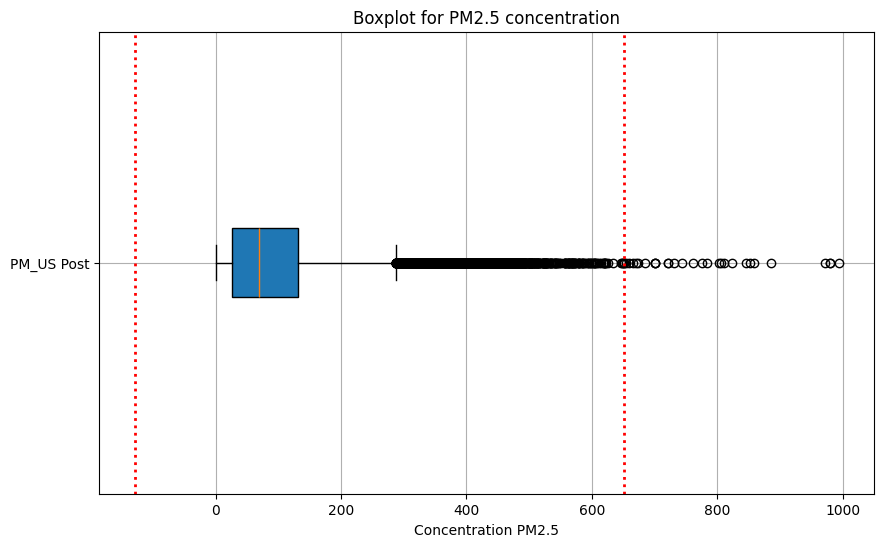

In [21]:
# Visual representation of outlier values
plt.figure(figsize=(10, 6))
plt.boxplot(df['PM_US Post'], vert=False, patch_artist=True)
plt.title('Boxplot for PM2.5 concentration')
plt.xlabel('Concentration PM2.5')
plt.yticks([1], ['PM_US Post'])
plt.grid(True)
plt.axvline(lower_bound, color='r', linestyle='dotted', linewidth=2, label=f'Outlier border (lower): {lower_bound:.2f}')
plt.axvline(upper_bound, color='r', linestyle='dotted', linewidth=2, label=f'Outlier border (upper): {upper_bound:.2f}')
plt.show()

We have values that are significantly outside the outlier range, but these are not something we should exclude from our data. It is not an error; rather, these values are from January 31, 2014, during the celebration of the Chinese New Year. The concentration of particles was exceptionally high on that day due to the use of fireworks and similar means of celebration.

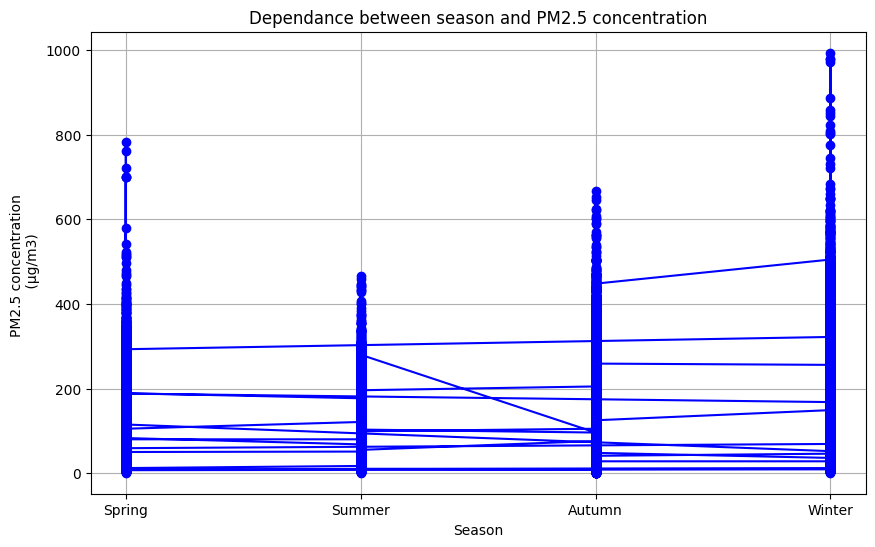

In [22]:
# Dependance between season and PM2.5 concentration
season_mapping = {1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'}

plt.figure(figsize=(10, 6))
plt.plot(df['season'], df['PM_US Post'], marker='o', linestyle='-', color='b')
plt.title('Dependance between season and PM2.5 concentration')
plt.xlabel("Season")
plt.ylabel("PM2.5 concentration \n (µg/m3)")
plt.xticks(df['season'].unique(), [season_mapping[season] for season in df['season'].unique()])

plt.grid(True)
plt.show()

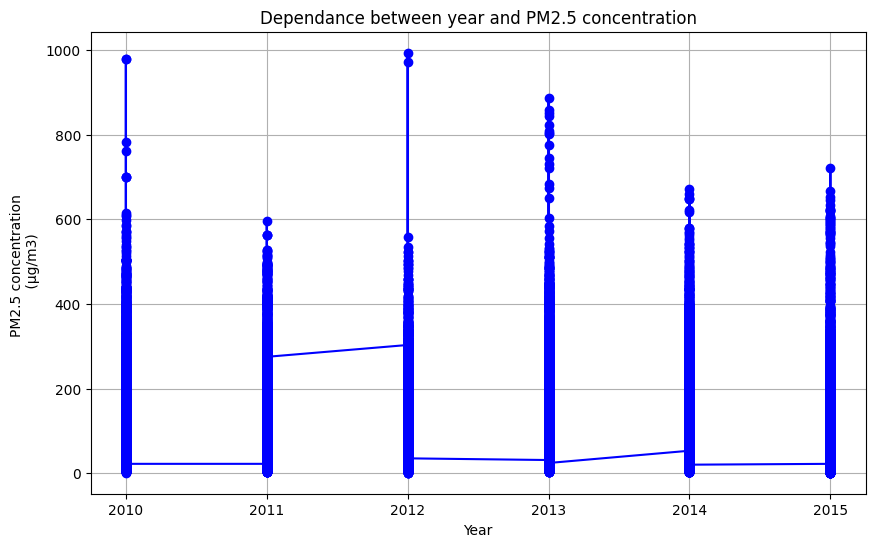

In [23]:
# Dependance between year and PM2.5 concentration
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['PM_US Post'], marker='o', linestyle='-', color='b')
plt.title('Dependance between year and PM2.5 concentration')
plt.xlabel('Year')
plt.ylabel('PM2.5 concentration \n (µg/m3)')
plt.grid(True)
plt.show()

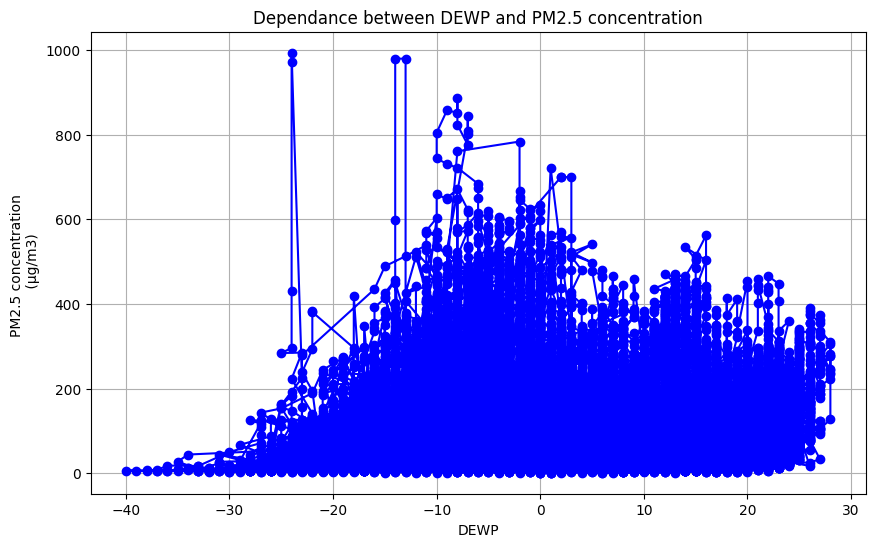

In [24]:
# Dependance between DEWP and PM2.5 concentration
plt.figure(figsize=(10, 6))
plt.plot(df['DEWP'], df['PM_US Post'], marker='o', linestyle='-', color='b')
plt.title('Dependance between DEWP and PM2.5 concentration')
plt.xlabel("DEWP")
plt.ylabel("PM2.5 concentration \n (µg/m3)")
plt.grid(True)
plt.show()

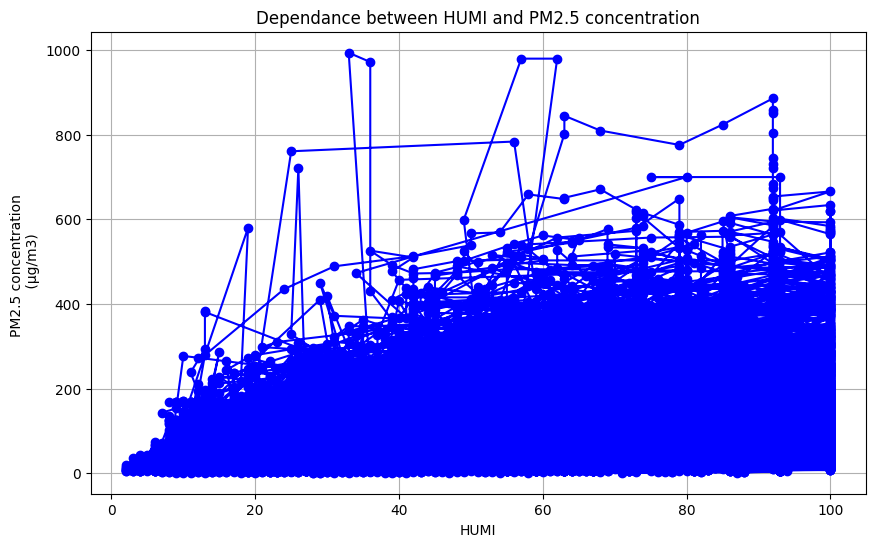

In [25]:
# Dependance between HUMI and PM2.5 concentration
plt.figure(figsize=(10, 6))
plt.plot(df['HUMI'], df['PM_US Post'], marker='o', color='b')
plt.title('Dependance between HUMI and PM2.5 concentration')
plt.xlabel("HUMI")
plt.ylabel("PM2.5 concentration \n (µg/m3)")
plt.grid(True)
plt.show()

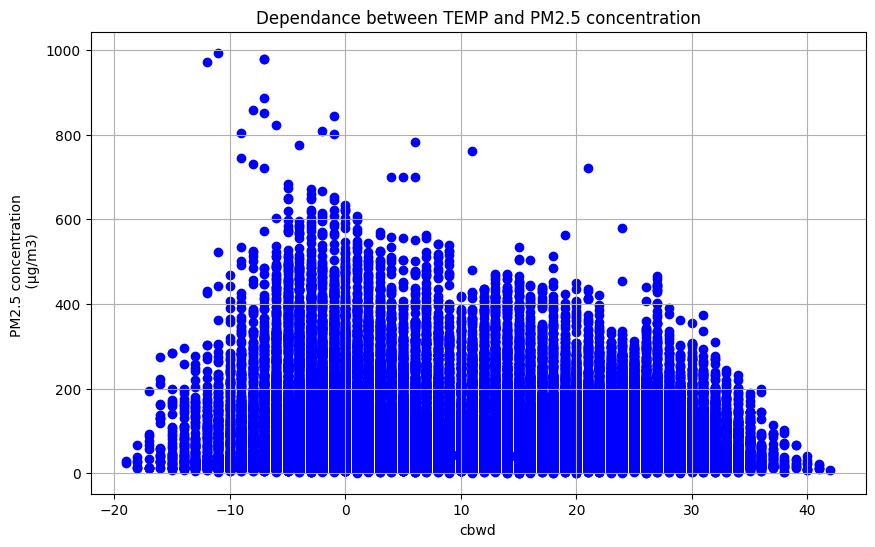

In [26]:
# Dependance between TEMP and PM2.5 concentration
plt.figure(figsize=(10, 6))
plt.scatter(df['TEMP'], df['PM_US Post'], marker='o', linestyle='-', color='b')
plt.title('Dependance between TEMP and PM2.5 concentration')
plt.xlabel("cbwd")
plt.ylabel("PM2.5 concentration \n (µg/m3)")
plt.grid(True)
plt.show()

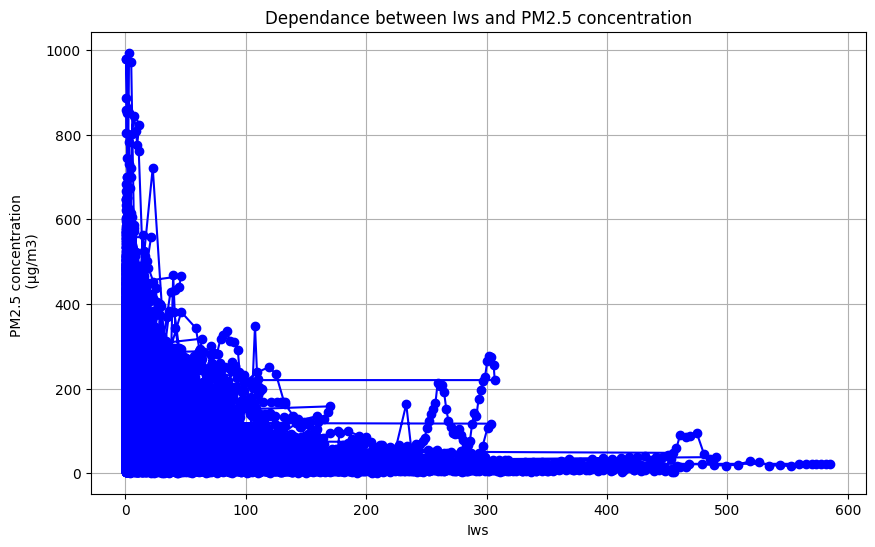

In [27]:
# Dependance between Iws and PM2.5 concentration
plt.figure(figsize=(10, 6))
plt.plot(df['Iws'], df['PM_US Post'], marker='o', linestyle='-', color='b')
plt.title('Dependance between Iws and PM2.5 concentration')
plt.xlabel("Iws")
plt.ylabel("PM2.5 concentration \n (µg/m3)")
plt.grid(True)
plt.show()

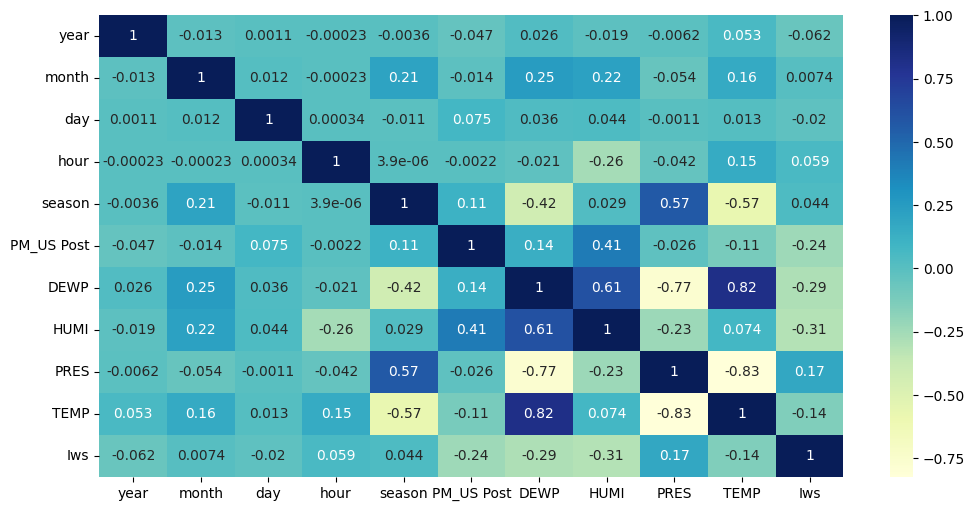

In [28]:
# Correlation matrix
plt.figure(figsize=(12,6))
corr_mat = df.corr(numeric_only=True)
sb.heatmap(corr_mat, annot=True, cmap="YlGnBu")
plt.show()

# Linear Regression Model

In [29]:
# Convert categorical features into numerical
df.loc[df['cbwd'] == 'cv', 'cbwd'] = 0
df.loc[df['cbwd'] == 'SW', 'cbwd'] = 1
df.loc[df['cbwd'] == 'SE', 'cbwd'] = 2
df.loc[df['cbwd'] == 'NW', 'cbwd'] = 3
df.loc[df['cbwd'] == 'NE', 'cbwd'] = 4

In [30]:
x = df.drop(['PM_US Post'], axis=1).copy()
y = df['PM_US Post'].copy()

# Create test and training set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [31]:
def model_evaluation(y, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1 - (1 - r2) * (N - 1) / (N - d - 1)

    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    res = pd.concat([pd.DataFrame(y.values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))

Mean squared error:  6451.602261492167
Mean absolute error:  56.99511386650725
Root mean squared error:  80.32186664596489
R2 score:  0.25450604357129036
R2 adjusted score:  0.2542605877503824
        y      y_pred
0   283.0  167.536968
1    53.0   69.264807
2    24.0  118.178737
3    32.0   14.693497
4    66.0  103.026177
5    18.0   22.459539
6   133.0  103.924855
7    56.0  110.742660
8    56.0  198.640933
9    78.0  134.086420
10   14.0   21.129653
11  532.0  163.334720
12    5.0  -29.478000
13   11.0   36.154940
14   52.0  124.046487
15   86.0   79.236649
16   96.0   82.127719
17   49.0  125.622324
18   58.0  159.020711
19  441.0  179.832609


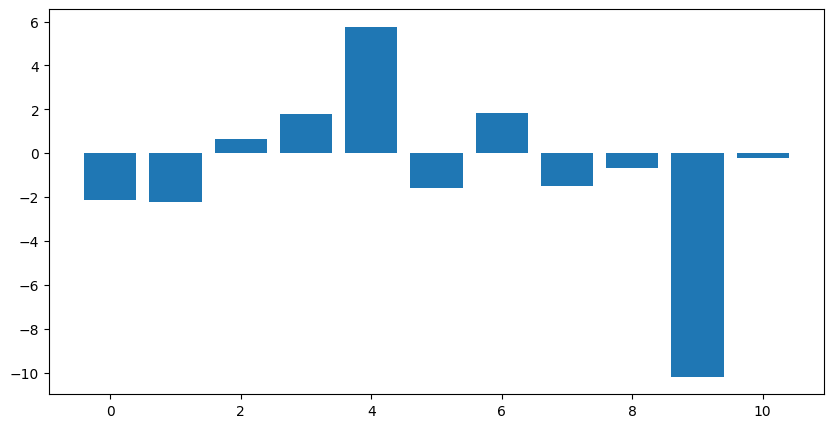

Coefficients:  [ -2.14404616  -2.24237502   0.63700717   1.76624023   5.76531494
  -1.57005003   1.82366638  -1.50579252  -0.66920962 -10.19412926
  -0.20480631]


In [32]:
# 1) Linear regression with hypothesis y=b0+b1x1+b2x2+...+bnxn
first_regression_model = LinearRegression(fit_intercept=True)
first_regression_model.fit(x_train, y_train)
y_predicted = first_regression_model.predict(x_test)
model_evaluation(y_test, y_predicted, x_train.shape[0], x_train.shape[1])

plt.figure(figsize=(10, 5))
plt.bar(range(len(first_regression_model.coef_)), first_regression_model.coef_)
plt.show()

print("Coefficients: ", first_regression_model.coef_)

In [33]:
# Feature standardization - Z normalization
scaler = StandardScaler()
scaler.fit(x_train)

x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

x_train_std = pd.DataFrame(x_train_std)
x_test_std = pd.DataFrame(x_test_std)

x_train_std.columns = list(x.columns)
x_test_std.columns = list(x.columns)

Mean squared error:  5057.353291844922
Mean absolute error:  49.54056680662992
Root mean squared error:  71.11507077859743
R2 score:  0.41561395731124506
R2 adjusted score:  0.4142644169193477
        y      y_pred
0   283.0  227.812096
1    53.0  102.086361
2    24.0   45.646861
3    32.0   33.642497
4    66.0   66.947505
5    18.0    8.948306
6   133.0  102.894628
7    56.0   72.384827
8    56.0  230.751656
9    78.0  166.082582
10   14.0   52.459946
11  532.0  175.979063
12    5.0   22.808485
13   11.0   26.754615
14   52.0  120.034042
15   86.0  105.157157
16   96.0  110.516513
17   49.0  115.935335
18   58.0  122.831277
19  441.0  321.732023


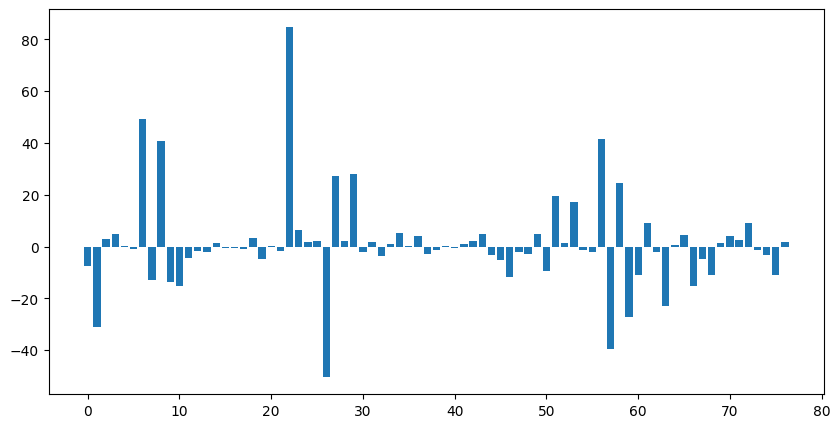

Coefficients [-7.46937374e+00 -3.11080218e+01  2.99127605e+00  4.92777701e+00
  1.01215912e-01 -7.18535513e-01  4.93028292e+01 -1.29083620e+01
  4.09340388e+01 -1.38330336e+01 -1.51773613e+01 -4.27290151e+00
 -1.83350088e+00 -2.16797149e+00  1.28326326e+00 -6.73112986e-01
 -6.10416929e-01 -8.55354059e-01  3.52042472e+00 -4.72531808e+00
  1.44708697e-01 -1.73233222e+00  8.48881839e+01  6.35278742e+00
  1.94879822e+00  2.24792220e+00 -5.02405474e+01  2.71744745e+01
  2.18083221e+00  2.78687584e+01 -1.88000481e+00  1.71390696e+00
 -3.68243388e+00  8.42730008e-01  5.27936294e+00  1.03781570e-01
  4.02452079e+00 -2.95891380e+00 -1.14807650e+00  6.98445384e-02
 -6.75305220e-01  1.21003221e+00  2.20020662e+00  4.99071427e+00
 -3.21064083e+00 -5.03670809e+00 -1.18898110e+01 -1.90099243e+00
 -2.97516275e+00  4.84401095e+00 -9.26130261e+00  1.95624506e+01
  1.47755268e+00  1.71435574e+01 -1.32207376e+00 -1.88085026e+00
  4.15863301e+01 -3.96859041e+01  2.45521987e+01 -2.73368727e+01
 -1.08415583

In [34]:
print("Number of features in Linear Regression Model:", len(first_regression_model.coef_))
print("Number of features in Polynomial Regression Model:", len(regression_model_degree.coef_))

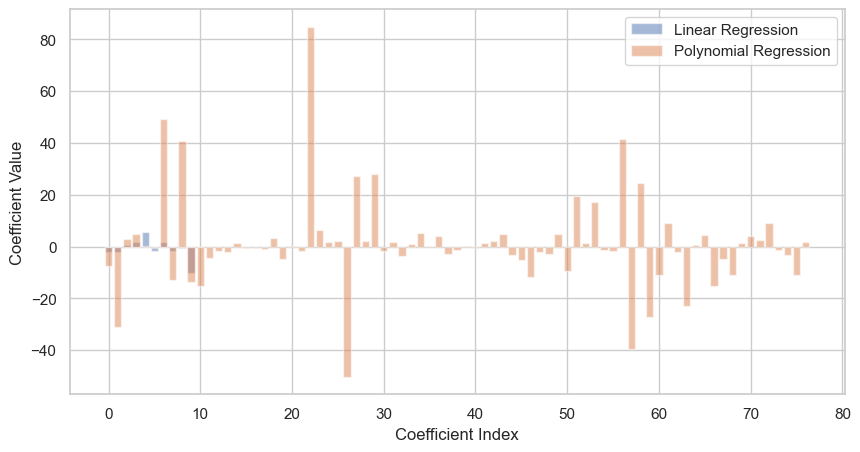

In [46]:
# 2. Compare coefficients
plt.figure(figsize=(10, 5))
plt.bar(range(len(first_regression_model.coef_)), first_regression_model.coef_, alpha=0.5, label='Linear Regression')
plt.bar(range(len(regression_model_degree.coef_)), regression_model_degree.coef_, alpha=0.5, label='Polynomial Regression')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

In [45]:
print("Number of features in Linear Regression Model:", len(first_regression_model.coef_))
print("Number of features in Polynomial Regression Model:", len(regression_model_degree.coef_))

Number of features in Linear Regression Model: 11
Number of features in Polynomial Regression Model: 77


Mean squared error:  5057.252774215133
Mean absolute error:  49.53158236152868
Root mean squared error:  71.11436404985376
R2 score:  0.41562557229965946
R2 adjusted score:  0.4142760587306067
        y      y_pred
0   283.0  227.709510
1    53.0  101.682459
2    24.0   46.026126
3    32.0   33.889726
4    66.0   66.873275
5    18.0    9.148231
6   133.0  103.351493
7    56.0   72.312809
8    56.0  230.913436
9    78.0  166.546398
10   14.0   52.436931
11  532.0  176.113588
12    5.0   23.154065
13   11.0   26.674315
14   52.0  120.138710
15   86.0  105.129955
16   96.0  110.196134
17   49.0  115.789348
18   58.0  123.292648
19  441.0  321.333530


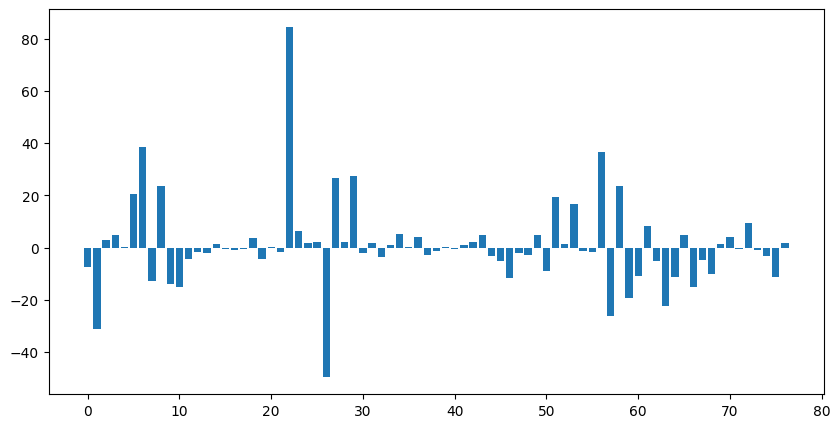

Coefficients - Ridge:  [-7.45321667e+00 -3.10041501e+01  2.99902259e+00  4.94055387e+00
  1.36695329e-01  2.07379231e+01  3.83744568e+01 -1.29081439e+01
  2.36388997e+01 -1.38550165e+01 -1.50589650e+01 -4.27135003e+00
 -1.83446839e+00 -2.16305352e+00  1.28808268e+00 -6.66442239e-01
 -8.89948557e-01 -7.10711250e-01  3.50273451e+00 -4.52245218e+00
  1.43893509e-01 -1.74287870e+00  8.46365744e+01  6.32457056e+00
  1.94078064e+00  2.28292804e+00 -4.94881546e+01  2.68187217e+01
  2.15055377e+00  2.73443893e+01 -1.87558390e+00  1.72992226e+00
 -3.67503131e+00  8.42452636e-01  5.27678627e+00  2.01685957e-01
  3.96515677e+00 -2.98532650e+00 -1.23831941e+00  7.18093496e-02
 -6.77677593e-01  1.20207372e+00  2.21440368e+00  4.85033027e+00
 -3.14041759e+00 -5.03791763e+00 -1.17725855e+01 -1.90159747e+00
 -2.97952647e+00  4.86751766e+00 -8.79025995e+00  1.92400959e+01
  1.48028597e+00  1.67064640e+01 -1.31645299e+00 -1.85582677e+00
  3.65225060e+01 -2.60346924e+01  2.37279119e+01 -1.94715438e+01
 -

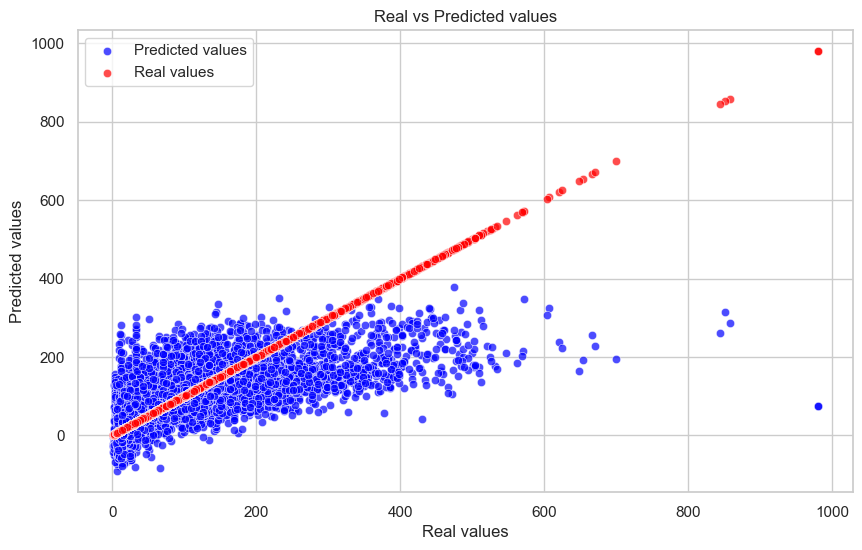

In [37]:
# Ridge regression
ridge_model = Ridge(alpha=4)
ridge_model.fit(x_inter_train, y_train)
y_predicted = ridge_model.predict(x_inter_test)

model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])

plt.figure(figsize=(10, 5))
plt.bar(range(len(ridge_model.coef_)), ridge_model.coef_)
plt.show()
print("Coefficients - Ridge: ", ridge_model.coef_)

# Prikazivanje koeficijenata
sb.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sb.scatterplot(x=y_test, y=y_predicted, color='blue', alpha=0.7, label='Predicted values')
sb.scatterplot(x=y_test, y=y_test, color='red', alpha=0.7, label='Real values')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Real vs Predicted values")
plt.show()

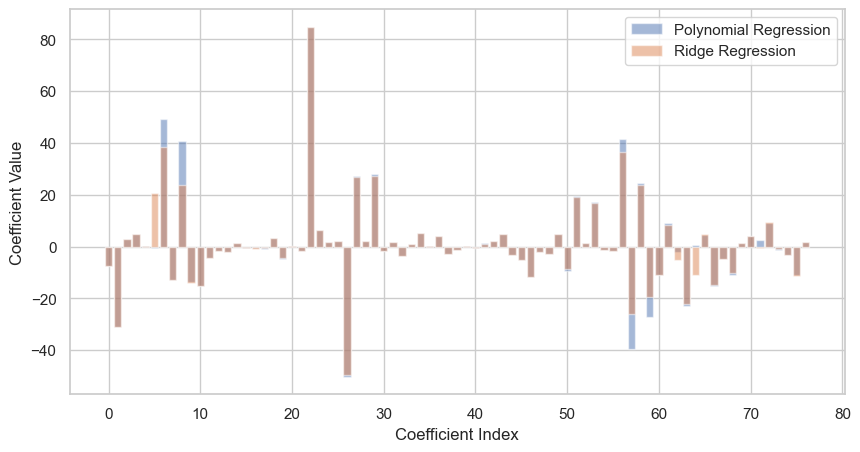

In [47]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(regression_model_degree.coef_)), regression_model_degree.coef_, alpha=0.5, label='Polynomial Regression')
plt.bar(range(len(ridge_model.coef_)), ridge_model.coef_, alpha=0.5, label='Ridge Regression')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

# KNN

In [48]:
# Adding a column where we will describe the danger based on PM2.5 particle levels.
new_df = df.assign(danger='NAN')
# Adding values to the 'danger' column based on the values of the 'PMUS Post' column.
new_df.loc[new_df['PM_US Post'] < 55.5, 'danger'] = 'safe'
new_df.loc[(new_df['PM_US Post'] > 55.4) & (new_df['PM_US Post'] < 150.5), 'danger'] = 'unsafe'
new_df.loc[new_df['PM_US Post'] > 150.4, 'danger'] = 'dangerous'

# Converting categorical features into numerical features.
new_df.loc[new_df['danger'] == 'safe', 'danger'] = 0
new_df.loc[new_df['danger'] == 'unsafe', 'danger'] = 1
new_df.loc[new_df['danger'] == 'dangerous', 'danger'] = 2

new_df.loc[new_df['cbwd'] == 'cv', 'cbwd'] = 0
new_df.loc[new_df['cbwd'] == 'SW', 'cbwd'] = 1
new_df.loc[new_df['cbwd'] == 'SE', 'cbwd'] = 2
new_df.loc[new_df['cbwd'] == 'NW', 'cbwd'] = 3
new_df.loc[new_df['cbwd'] == 'NE', 'cbwd'] = 4

Xtr = new_df.iloc[:, :-1] 
Ytr = new_df.iloc[:, -1].astype('int')

In [49]:
x_train, x_test, y_train, y_test = train_test_split(Xtr, Ytr, test_size=0.20, train_size=0.80, random_state=42)

In [50]:
# Confusion matrix for the 'safe' class
def evaluation_classif_class_safe(conf_mat):
    TPc = conf_mat[0, 0]
    TNc1 = conf_mat[1, 1]
    TNc2 = conf_mat[1, 2]
    TNc3 = conf_mat[2, 1]
    TNc4 = conf_mat[2, 2]
    FPc1 = conf_mat[1, 0]
    FPc2 = conf_mat[2, 0]
    FNc1 = conf_mat[0, 1]
    FNc2 = conf_mat[0, 2]

    precision = TPc / (TPc + FPc1 + FPc2)
    accuracy = (TPc + TNc1 + TNc2 + TNc3 + TNc4) / (TPc + TNc1 + TNc2 + TNc3 + TNc4 + FPc1 + FPc2 + FNc1 + FNc2)
    sensitivity = TPc / (TPc + FPc1 + FPc2)
    specificity = (TNc1 + TNc2 + TNc3 + TNc4) / (TNc1 + TNc2 + TNc3 + TNc4 + FPc1 + FPc2)
    F_score = 2 * precision * sensitivity / (precision + sensitivity)
    print("Class safe: ")
    print('precision: ', precision)
    print('accuracy: ', accuracy)
    print('sensitivity/recall: ', sensitivity)
    print('specificity: ', specificity)
    print('F score: ', F_score)
    print("")
    return accuracy
# Confusion matrix for the 'unsafe' class
def evaluation_classif_class_unsafe(conf_mat):
    TPp = conf_mat[1, 1]
    TNp1 = conf_mat[0, 0]
    TNp2 = conf_mat[0, 2]
    TNp3 = conf_mat[2, 0]
    TNp4 = conf_mat[2, 2]
    FPp1 = conf_mat[0, 1]
    FPp2 = conf_mat[2, 1]
    FNp1 = conf_mat[1, 0]
    FNp2 = conf_mat[1, 2]

    precision1 = TPp / (TPp + FPp1 + FPp2)
    accuracy1 = (TPp + TNp1 + TNp2 + TNp3 + TNp4) / (TPp + TNp1 + TNp2 + TNp3 + TNp4 + FPp1 + FPp2 + FNp1 + FNp2)
    sensitivity1 = TPp / (TPp + FPp1 + FPp2)
    specificity1 = (TNp1 + TNp2 + TNp3 + TNp4) / (TNp1 + TNp2 + TNp3 + TNp4 + FPp1 + FPp2)
    F_score1 = 2 * precision1 * sensitivity1 / (precision1 + sensitivity1)
    print("Class unsafe: ")
    print('precision: ', precision1)
    print('accuracy: ', accuracy1)
    print('sensitivity/recall: ', sensitivity1)
    print('specificity: ', specificity1)
    print('F score: ', F_score1)
    print("")
    return accuracy1


# Confusion matrix for the 'dangerous' class
def evaluation_classif_class_dangerous(conf_mat):
    TPps = conf_mat[2, 2]
    TNps1 = conf_mat[0, 0]
    TNps2 = conf_mat[0, 1]
    TNps3 = conf_mat[1, 0]
    TNps4 = conf_mat[1, 1]
    FPps1 = conf_mat[0, 2]
    FPps2 = conf_mat[1, 2]
    FNps1 = conf_mat[2, 0]
    FNps2 = conf_mat[2, 1]
    precision2 = TPps / (TPps + FPps1 + FPps2)
    accuracy2 = (TPps + TNps1 + TNps2 + TNps3 + TNps4) / (
            TPps + TNps1 + TNps2 + TNps3 + TNps4 + FPps1 + FPps2 + FNps1 + FNps2)
    sensitivity2 = TPps / (TPps + FPps1 + FPps2)
    specificity2 = (TNps1 + TNps2 + TNps3 + TNps4) / (TNps1 + TNps2 + TNps3 + TNps4 + FPps1 + FPps2)
    F_score2 = 2 * precision2 * sensitivity2 / (precision2 + sensitivity2)
    print("Class dangerous: ")
    print('precision: ', precision2)
    print('accuracy: ', accuracy2)
    print('sensitivity/recall: ', sensitivity2)
    print('specificity: ', specificity2)
    print('F score: ', F_score2)
    print("")
    return accuracy2

In [51]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 14),
    'weights': ['distance', 'uniform'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

# Initialize KNeighborsClassifier
knn = KNeighborsClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10)
grid_search.fit(x_train, y_train)

# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print('Best accuracy:', best_accuracy)
print('Best parameters:', best_params)


Best accuracy: 0.9875529481524401
Best parameters: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}


In [54]:
# kNN classifier on test set
classifierknn = KNeighborsClassifier(n_neighbors=12, metric='manhattan', weights='distance')
classifierknn.fit(x_train, y_train)
y_pred1 = classifierknn.predict(x_test)
conf_mat1 = confusion_matrix(y_test, y_pred1)
print(y_pred1)
print('Final confusion matrix: ')
print(conf_mat1)

avg_accuracy = ((evaluation_classif_class_safe(conf_mat1) + evaluation_classif_class_unsafe(
    conf_mat1) + evaluation_classif_class_dangerous(conf_mat1)) / 3)
precision_scoremicro=precision_score(y_test, y_pred1, average='micro')
precision_scoremarco=precision_score(y_test, y_pred1, average='macro')
recall_scoremicro=recall_score(y_test, y_pred1, average='micro')
recall_scoremarco=recall_score(y_test, y_pred1, average='macro')
f1_scoremicro=f1_score(y_test, y_pred1, average='micro')
f1_scoremacro=f1_score(y_test, y_pred1, average='macro')
print("Average accuracy: ", avg_accuracy)
print('Micro precision: ', precision_scoremicro)
print('Macro precision: ', precision_scoremarco)
print('Micro sensitivity/recall: ', recall_scoremicro)
print('Macro sensitivity/recall: ', recall_scoremarco)
print('Micro F score: ', f1_scoremicro)
print('Macro F score: ', f1_scoremacro)

[2 0 0 ... 2 2 0]
Final confusion matrix: 
[[4373   49    0]
 [  58 3831   16]
 [   0   34 2084]]
Class safe: 
precision:  0.9869104039720153
accuracy:  0.9897558640497846
sensitivity/recall:  0.9869104039720153
specificity:  0.9903702473850241
F score:  0.9869104039720153

Class unsafe: 
precision:  0.9787940725600409
accuracy:  0.9849688846337961
sensitivity/recall:  0.9787940725600409
specificity:  0.9873088685015291
F score:  0.9787940725600409

Class dangerous: 
precision:  0.9923809523809524
accuracy:  0.9952130205840115
sensitivity/recall:  0.9923809523809524
specificity:  0.9980785396901646
F score:  0.9923809523809524

Average accuracy:  0.9899792564225307
Micro precision:  0.9849688846337961
Macro precision:  0.9860284763043362
Micro sensitivity/recall:  0.9849688846337961
Macro sensitivity/recall:  0.9846386990206059
Micro F score:  0.9849688846337961
Macro F score:  0.98532681610678


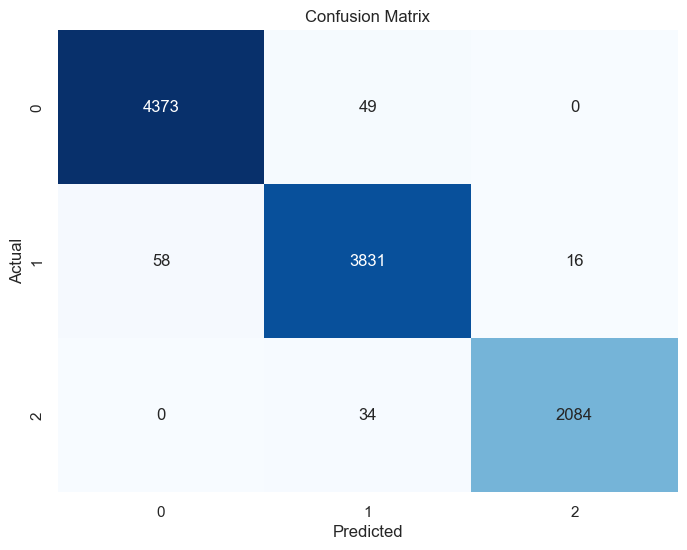

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [58]:
def accuracy(confusion_matrix):
    correct_predictions = confusion_matrix.trace()
    total_predictions = confusion_matrix.sum()
    accuracy = correct_predictions / total_predictions
    return accuracy

# Example usage:
accuracy_value = accuracy(conf_mat1)
print("Accuracy:", accuracy_value)


Accuracy: 0.9849688846337961


# Voting Regressor

In [ ]:

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Define individual classifiers
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)
logistic_regression = LogisticRegression()

# Train individual classifiers
logistic_regression.fit(x_inter_train, y_train) 


# Make predictions using each individual classifier
y_pred_lr = logistic_regression.predict(x_inter_test)

# Combine predictions into a DataFrame
combined_predictions = pd.DataFrame({'LOR': y_pred_lr, 'LNR': y_predicted})

# Apply the voting rule (simple majority voting)
combined_predictions['Voting'] = combined_predictions.mode(axis=1)[0]
combined_predictions['Voting'] = combined_predictions['Voting'].round()  # Round to the nearest integer

conf_mat_combined = confusion_matrix(y_test, combined_predictions['Voting'])

print('Final confusion matrix (Combined Predictions): ')
print(conf_mat_combined)

# Calculate evaluation metrics
precision_micro = precision_score(y_test, combined_predictions['Voting'], average='micro')
recall_micro = recall_score(y_test, combined_predictions['Voting'], average='micro')
f1_score_micro = f1_score(y_test, combined_predictions['Voting'], average='micro')

precision_macro = precision_score(y_test, combined_predictions['Voting'], average='macro')
recall_macro = recall_score(y_test, combined_predictions['Voting'], average='macro')n
f1_score_macro = f1_score(y_test, combined_predictions['Voting'], average='macro')

print("Micro precision (Combined Predictions): ", precision_micro)
print("Macro precision (Combined Predictions): ", precision_macro)
print("Micro recall (Combined Predictions): ", recall_micro)
print("Macro recall (Combined Predictions): ", recall_macro)
print("Micro F1-score (Combined Predictions): ", f1_score_micro)
print("Macro F1-score (Combined Predictions): ", f1_score_macro)

In [395]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming df, x, y, x_train, x_test, y_train, y_test, and model_evaluation are defined as in your code

# 1) Linear regression model
first_regression_model = LinearRegression(fit_intercept=True)
first_regression_model.fit(x_train, y_train)
y_predicted_lr = first_regression_model.predict(x_test)

# 2) Ridge regression model
ridge_regression_model = Ridge(alpha=1.0)
ridge_regression_model.fit(x_train, y_train)
y_predicted_ridge = ridge_regression_model.predict(x_test)

# Voting Regressor
voting_regressor = VotingRegressor(estimators=[('lr', first_regression_model), ('ridge', ridge_regression_model)])
voting_regressor.fit(x_train, y_train)
y_predicted_voting = voting_regressor.predict(x_test)

# Model evaluation
print("Linear Regression:")
model_evaluation(y_test, y_predicted_lr, x_train.shape[0], x_train.shape[1])
print("\nRidge Regression:")
model_evaluation(y_test, y_predicted_ridge, x_train.shape[0], x_train.shape[1])
print("\nVoting Regressor:")
model_evaluation(y_test, y_predicted_voting, x_train.shape[0], x_train.shape[1])



# Feature standardization - Z normalization
scaler = StandardScaler()
scaler.fit(x_train)

x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

x_train_std = pd.DataFrame(x_train_std, columns=x_train.columns)
x_test_std = pd.DataFrame(x_test_std, columns=x_test.columns)

Linear Regression:
Mean squared error:  6451.602261492159
Mean absolute error:  56.995113866507594
Root mean squared error:  80.32186664596485
R2 score:  0.25450604357129125
R2 adjusted score:  0.2542605877503833
        y      y_pred
0   283.0  167.536968
1    53.0   69.264807
2    24.0  118.178737
3    32.0   14.693497
4    66.0  103.026177
5    18.0   22.459539
6   133.0  103.924855
7    56.0  110.742660
8    56.0  198.640933
9    78.0  134.086420
10   14.0   21.129653
11  532.0  163.334720
12    5.0  -29.478000
13   11.0   36.154940
14   52.0  124.046487
15   86.0   79.236649
16   96.0   82.127719
17   49.0  125.622324
18   58.0  159.020711
19  441.0  179.832609

Ridge Regression:
Mean squared error:  6451.6014977314335
Mean absolute error:  56.995102075782825
Root mean squared error:  80.3218618915886
R2 score:  0.25450613182518267
R2 adjusted score:  0.25426067603333247
        y      y_pred
0   283.0  167.536411
1    53.0   69.265094
2    24.0  118.179013
3    32.0   14.693859
4

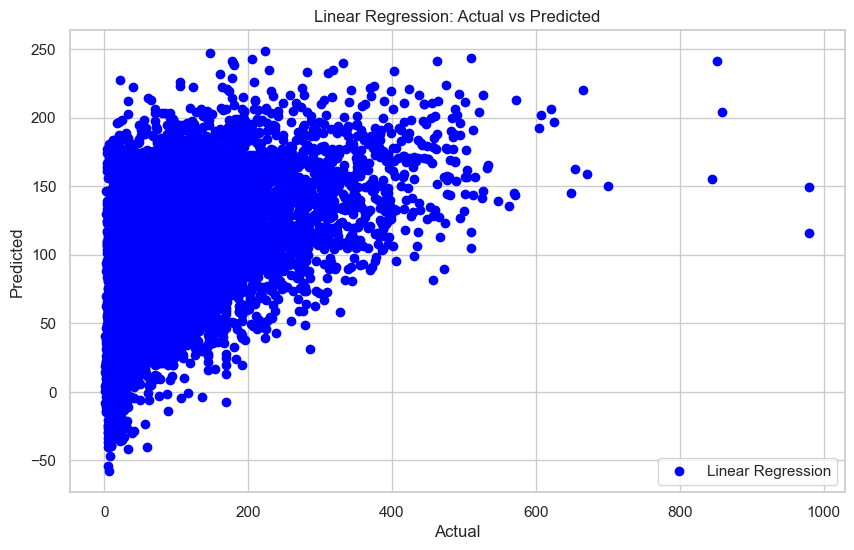

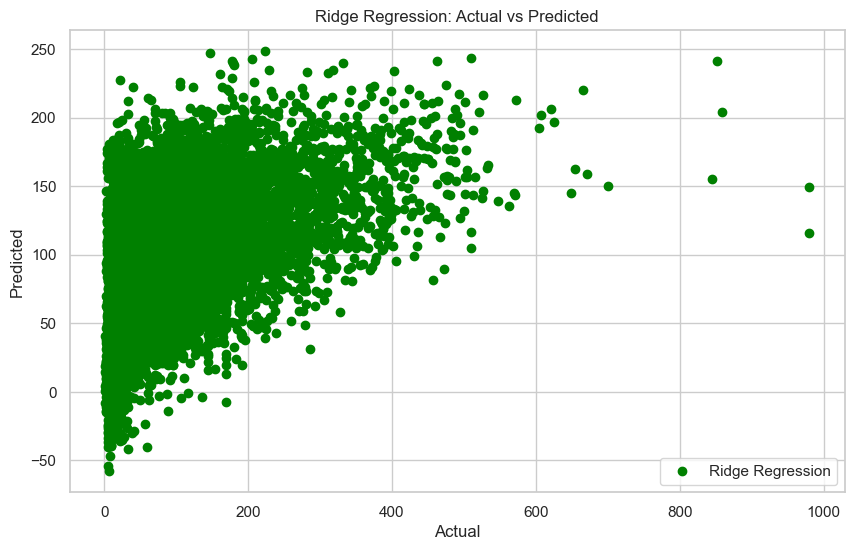

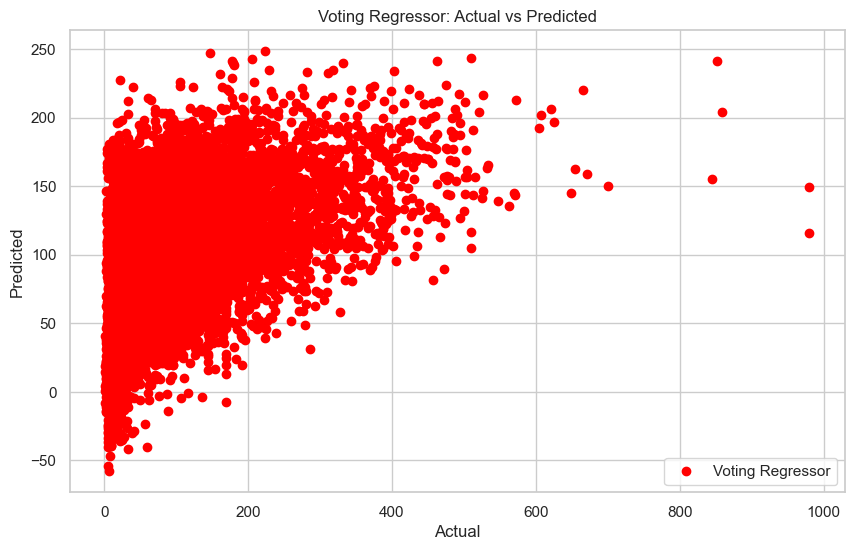

In [394]:
# Scatter plot for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predicted_lr, color='blue', label='Linear Regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Scatter plot for Ridge Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predicted_ridge, color='green', label='Ridge Regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Scatter plot for Voting Regressor
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predicted_voting, color='red', label='Voting Regressor')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Voting Regressor: Actual vs Predicted')
plt.legend()
plt.show()

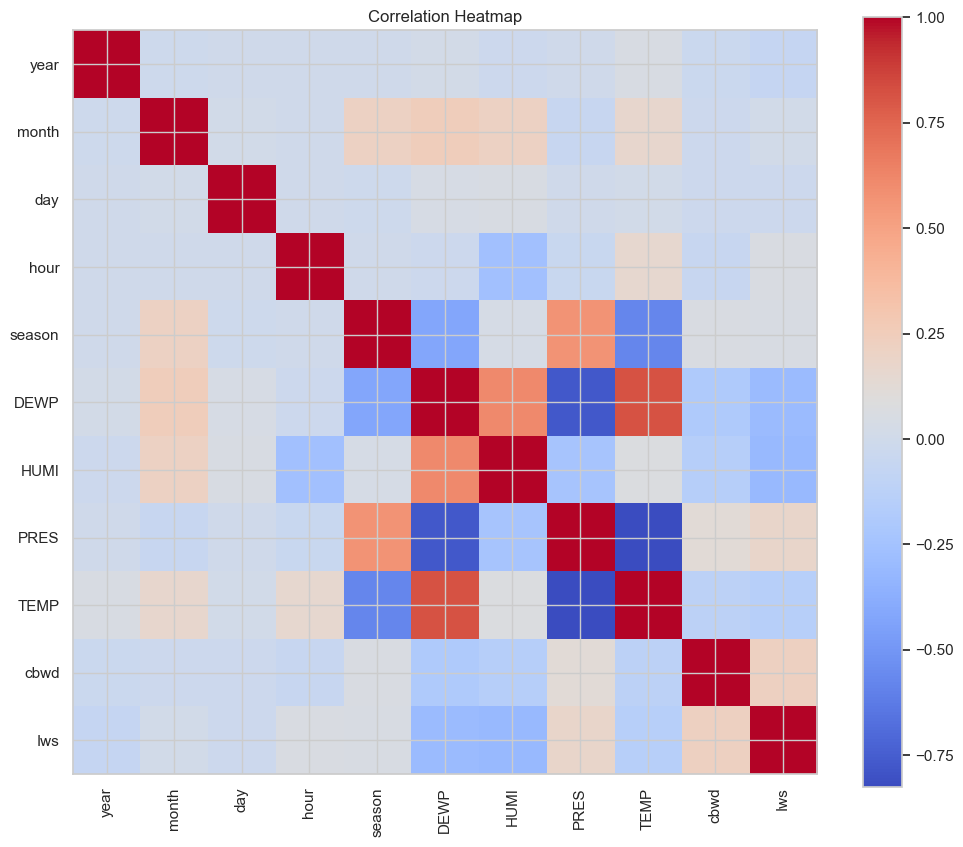

In [396]:
correlation_matrix = x_train.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

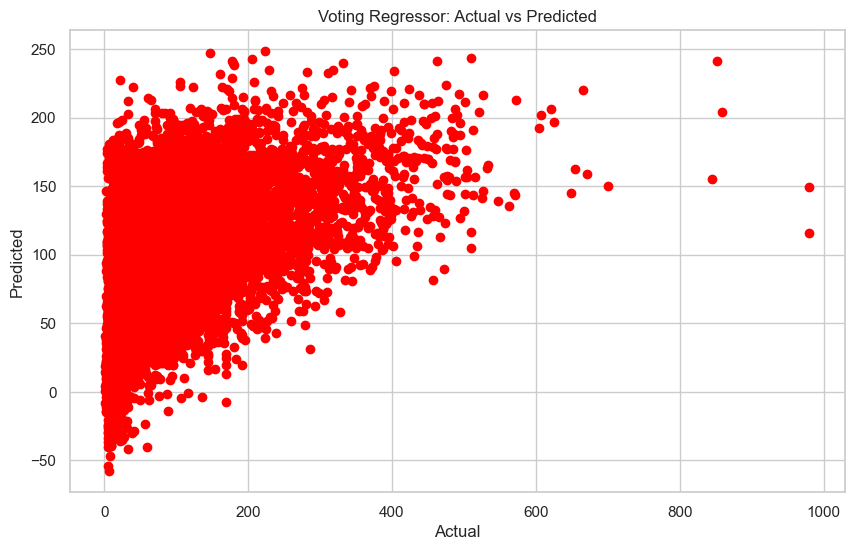

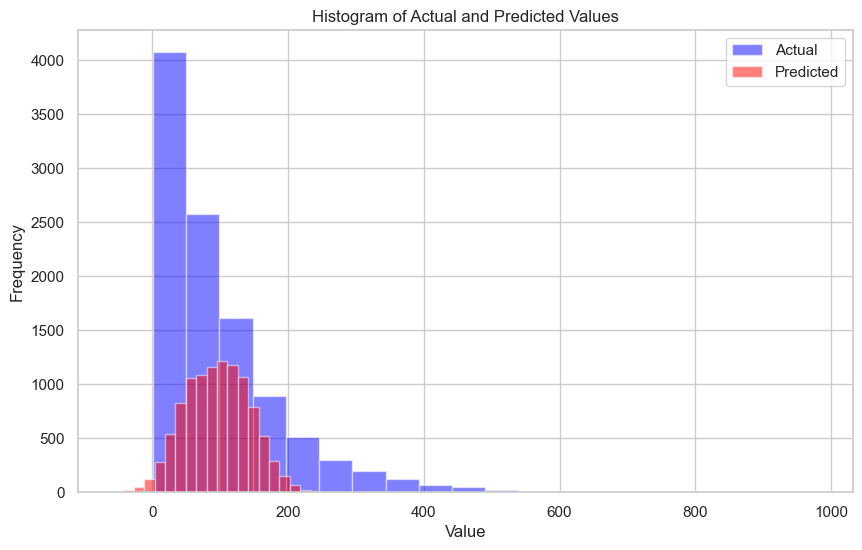

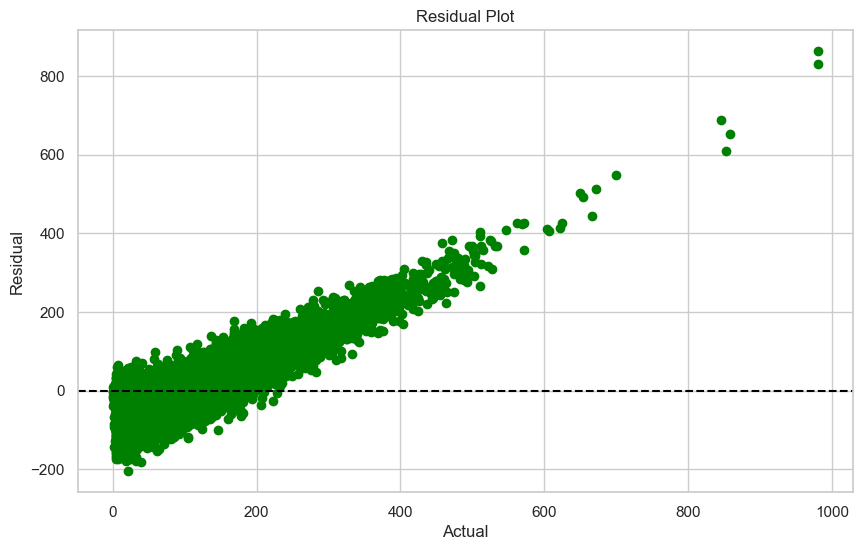

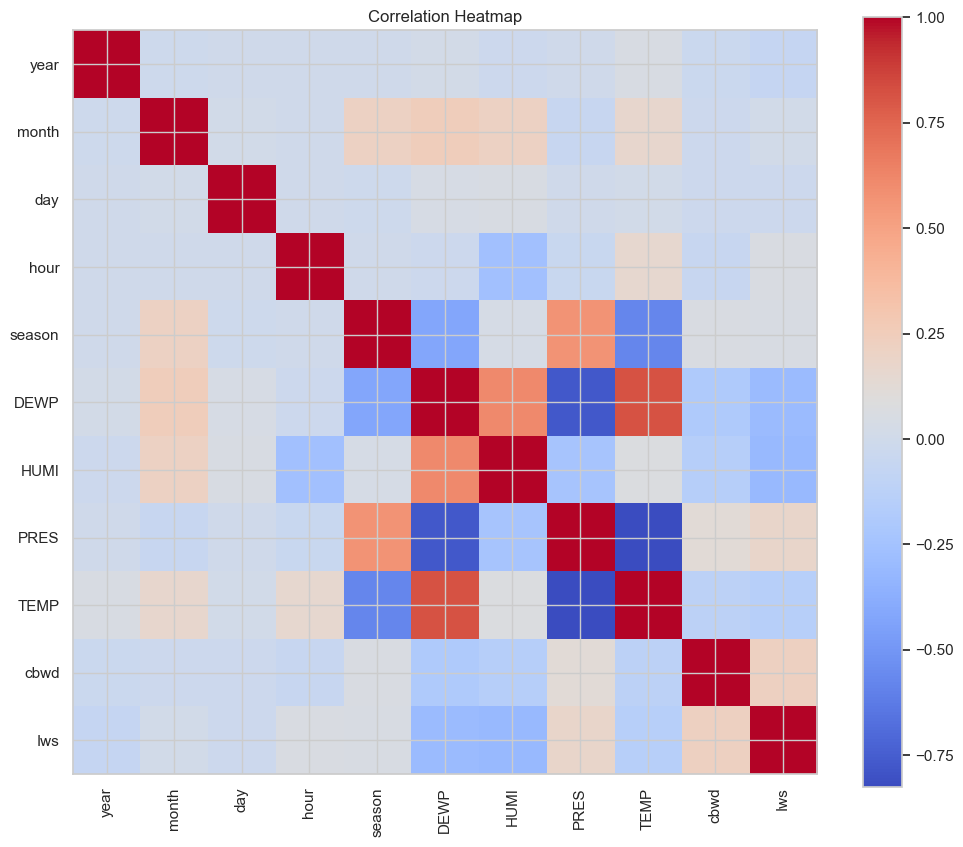

In [397]:
# Scatter plot between actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predicted_voting, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Voting Regressor: Actual vs Predicted')
plt.show()

# Histogram of the target variable and predicted values
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=20, alpha=0.5, color='blue', label='Actual')
plt.hist(y_predicted_voting, bins=20, alpha=0.5, color='red', label='Predicted')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Actual and Predicted Values')
plt.legend()
plt.show()

# Residual plot
residuals = y_test - y_predicted_voting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='green')
plt.xlabel('Actual')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# Calculate correlation matrix
correlation_matrix = x_train.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()